In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
drive_path = '/content/drive/MyDrive/efficientnet-v2'
import os
os.chdir(drive_path)

Mounted at /content/drive


In [ ]:
# !pip install tensorflow= 2.5.0
# !pip install tensorflow_hub= 0.12.0

In [ ]:
import tensorflow_hub as hub
import json
import shutil
from skimage.io import imread, imsave
from glob import glob
import cv2
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
import os
import matplotlib.pylab as plt
import numpy as np
import random
import tensorflow as tf
import tensorflow_hub as hub
from zipfile import ZipFile

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation
from tensorflow.keras.backend import sigmoid
from tensorflow_hub import KerasLayer

print('TF version:', tf.__version__)
print('Hub version:', hub.__version__)
print('Phsical devices:', tf.config.list_physical_devices())

TF version: 2.7.0
Hub version: 0.12.0
Phsical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# EfficientNetV2 with tf-hub


<table class="tfo-notebook-buttons" align="left">
<td>
  <a target="_blank"  href="https://github.com/google/automl/blob/master/efficientnetv2/tfhub.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on github
  </a>
</td><td>
  <a target="_blank"  href="https://colab.sandbox.google.com/github/google/automl/blob/master/efficientnetv2/tfhub.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td><td>
    <!----<a href="https://tfhub.dev/google/collections/image/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />TF Hub models</a>--->
  </td>
</table>

## 1.Introduction

[EfficientNetV2](https://arxiv.org/abs/2104.00298) is a family of classification models, with better accuracy, smaller size, and faster speed than previous models.


This doc describes some examples with EfficientNetV2 tfhub. For more details, please visit the official code: https://github.com/google/automl/tree/master/efficientnetv2

## 2.Select the TF2 SavedModel module to use

In [ ]:
def get_hub_url_and_isize(model_name, ckpt_type, hub_type):
  if ckpt_type == '-1k':
    ckpt_type = ''  # json doesn't support empty string
  
  hub_url_map = {
    'efficientnetv2-b0': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b0/{hub_type}',
    'efficientnetv2-b1': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b1/{hub_type}',
    'efficientnetv2-b2': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b2/{hub_type}',
    'efficientnetv2-b3': f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-b3/{hub_type}',
    'efficientnetv2-s':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-s/{hub_type}',
    'efficientnetv2-m':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-m/{hub_type}',
    'efficientnetv2-l':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-l/{hub_type}',
    'efficientnetv2-s-21k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-s-21k/{hub_type}',
    'efficientnetv2-m-21k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-m-21k/{hub_type}',
    'efficientnetv2-l-21k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-l-21k/{hub_type}',
    'efficientnetv2-s-21k-ft1k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-s-21k-ft1k/{hub_type}',
    'efficientnetv2-m-21k-ft1k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-m-21k-ft1k/{hub_type}',
    'efficientnetv2-l-21k-ft1k':  f'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-l-21k-ft1k/{hub_type}',
      
    # efficientnetv1
    'efficientnet_b0': f'https://tfhub.dev/tensorflow/efficientnet/b0/{hub_type}/1',
    'efficientnet_b1': f'https://tfhub.dev/tensorflow/efficientnet/b1/{hub_type}/1',
    'efficientnet_b2': f'https://tfhub.dev/tensorflow/efficientnet/b2/{hub_type}/1',
    'efficientnet_b3': f'https://tfhub.dev/tensorflow/efficientnet/b3/{hub_type}/1',
    'efficientnet_b4': f'https://tfhub.dev/tensorflow/efficientnet/b4/{hub_type}/1',
    'efficientnet_b5': f'https://tfhub.dev/tensorflow/efficientnet/b5/{hub_type}/1',
    'efficientnet_b6': f'https://tfhub.dev/tensorflow/efficientnet/b6/{hub_type}/1',
    'efficientnet_b7': f'https://tfhub.dev/tensorflow/efficientnet/b7/{hub_type}/1',
  }
  
  image_size_map = {
    'efficientnetv2-b0': 224,
    'efficientnetv2-b1': 240,
    'efficientnetv2-b2': 260,
    'efficientnetv2-b3': 300,
    'efficientnetv2-s':  384,
    'efficientnetv2-m':  480,
    'efficientnetv2-l':  480,
  
    'efficientnet_b0': 224,
    'efficientnet_b1': 240,
    'efficientnet_b2': 260,
    'efficientnet_b3': 300,
    'efficientnet_b4': 380,
    'efficientnet_b5': 456,
    'efficientnet_b6': 528,
    'efficientnet_b7': 600,
  }
  
  hub_url = hub_url_map.get(model_name + ckpt_type)
  image_size = image_size_map.get(model_name, 224)
  return hub_url, image_size


## 3.Inference with Panda image

In [ ]:
# # Build model
# import tensorflow_hub as hub
# model_name = 'efficientnetv2-s' #@param {type:'string'}
# ckpt_type = '-21k-ft1k'   # @param ['-21k', '-21k-ft1k', '-1k']
# hub_type = 'classification' # @param ['classification', 'feature-vector']
# hub_url, image_size = get_hub_url_and_isize(model_name, ckpt_type, hub_type)
# tf.keras.backend.clear_session()
# m = hub.KerasLayer(hub_url, trainable=False)
# m.build([None, 224, 224, 3])  # Batch input shape.

# # Download label map file and image
# labels_map = '/tmp/labels_map.txt'
# image_file = '/tmp/panda.jpg'
# tf.keras.utils.get_file(image_file, 'https://upload.wikimedia.org/wikipedia/commons/f/fe/Giant_Panda_in_Beijing_Zoo_1.JPG')
# tf.keras.utils.get_file(labels_map, 'https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/eval_data/labels_map.txt')

# # preprocess image.
# image = tf.keras.preprocessing.image.load_img(image_file, target_size=(224, 224))
# image = tf.keras.preprocessing.image.img_to_array(image)
# image = (image - 128.) / 128.
# logits = m(tf.expand_dims(image, 0), False)

# # Output classes and probability
# pred = tf.keras.layers.Softmax()(logits)
# idx = tf.argsort(logits[0])[::-1][:5].numpy()
# import ast
# classes = ast.literal_eval(open(labels_map, "r").read())
# for i, id in enumerate(idx):
#   print(f'top {i+1} ({pred[0][id]*100:.1f}%):  {classes[id]} ')
# from IPython import display
# display.display(display.Image(image_file))

## 4.Finetune with Flowers dataset.

Get hub_url and image_size


In [ ]:
# Build model
model_name = 'efficientnetv2-b0' #@param {type:'string'}
ckpt_type = '-1k'   # @param ['-21k', '-21k-ft1k', '-1k']
hub_type = 'feature-vector' # @param ['feature-vector']
batch_size =  32#@param {type:"integer"}
hub_url, image_size = get_hub_url_and_isize(model_name, ckpt_type, hub_type)

Get dataset

In [ ]:
# data_dir = tf.keras.utils.get_file(
#     'flower_photos',
#     'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
#     untar=True)
    
# datagen_kwargs = dict(rescale=1./255, validation_split=.20)
# dataflow_kwargs = dict(target_size=(image_size, image_size),
#                        batch_size=batch_size,
#                        interpolation="bilinear")

# valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     **datagen_kwargs)
# valid_generator = valid_datagen.flow_from_directory(
#     data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

# do_data_augmentation = True #@param {type:"boolean"}
# if do_data_augmentation:
#   train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#       rotation_range=40,
#       horizontal_flip=True,
#       width_shift_range=0.2, height_shift_range=0.2,
#       shear_range=0.2, zoom_range=0.2,
#       **datagen_kwargs)
# else:
#   train_datagen = valid_datagen
# train_generator = train_datagen.flow_from_directory(
#     data_dir, subset="training", shuffle=True, **dataflow_kwargs)

In [ ]:
# zip ファイルを content 直下に解凍
zip_name = '20211224_hirox_2class.zip' #@param {"type": "string"}

zip_path = os.path.join(drive_path, 'zip_images', zip_name)
# assert os.path.exists(zip_path)
dataset_dir = f'/content/{zip_name[:-4]}'
with ZipFile(zip_path) as existing_zip:
    existing_zip.extractall(f'/content/{zip_name[:-4]}')

# # テストデータも解凍する場合
# test_zip_name = '20210701_hirox_validation.zip'
# test_zip_path = os.path.join(drive_path, 'zip_images', test_zip_name)
# with ZipFile(test_zip_path) as existing_zip:
#     existing_zip.extractall(f'/content/{test_zip_name[:-4]}')

print('Done')

Done


In [ ]:
# もろもろ定義

# 入力された画像を，指定したサイズの正方形にリサイズする
def SquareResize(img, size, background = 'mean'):
    h, w = img.shape[:2]
    mag = size / max(h, w)
    img2 = cv2.resize(img ,(int(w * mag), int(h * mag)))
    
    if background == 'mean':
        background = int(np.mean(img))
    img3 = np.ones((size, size, 3), dtype = "u1") * background
    if h > w:
        img3[0 : img2.shape[0], int((size - img2.shape[1]) / 2): int((size + img2.shape[1]) / 2)] = img2
    else:
        img3[int((size - img2.shape[0]) / 2) : int((size + img2.shape[0]) / 2), 0:img2.shape[1]] = img2
    
    return(img3)

# json file の保存用
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

# モデルの活性化関数
# https://towardsdatascience.com/comparison-of-activation-functions-for-deep-neural-networks-706ac4284c8a
class SwishActivation(Activation):
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'
def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

# 終了時に音を出す
# https://qiita.com/skiing_LAL10/items/78be5e7aaaffe461c3ac
def beep():
    from google.colab import output
    output.eval_js('new Audio(\
    "https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg")\
    .play()') 

In [ ]:
TRAIN_PATH = '/content/train'
VAL_PATH = '/content/val'
TEST_PATH = '/content/test'
model_dir = drive_path + '/models'

In [ ]:
# 画像の水増し方法をクラス毎に指定
"""
0: augment なし
1: 90°回転のみ
2: 90°回転 & 左右反転
3: 90°回転 & 左右反転 & 上下反転
小数：downsampling
"""
aug_dict = {'default': 1} #@param{type:"raw"}

In [ ]:
# 画像を所定のサイズの正方形にリサイズして書き出し
train_val_split = 0.8 #@param {type:"integer"} # データが train になる確率 
class_names = ['tooth', 'noise'] #@param

###########################################

if os.path.exists(TRAIN_PATH):
    shutil.rmtree(TRAIN_PATH)
if os.path.exists(VAL_PATH):
    shutil.rmtree(VAL_PATH)
for cl in class_names:
    print(cl)
    cnt = 0
    train_cl_dir = f'/content/train/{cl}'
    val_cl_dir = f'/content/val/{cl}'
    os.makedirs(train_cl_dir, exist_ok=True)
    os.makedirs(val_cl_dir, exist_ok=True)

    paths = glob(os.path.join(dataset_dir, cl, '*.jpg'))
    for p in paths:
        if cnt % 1000 == 0:
            print(f'{cnt} / {len(paths)}')
        cnt += 1
        img = imread(p)
        new_img = SquareResize(img, image_size)

        # train か val のどちらかに書き出し
        skip = False
        if np.random.rand() < train_val_split:
            # train
            if cl in aug_dict.keys():
                if aug_dict[cl] == int(aug_dict[cl]):
                    num_aug = aug_dict[cl]
                else:
                    num_aug = 0
                    if np.random.rand() > aug_dict[cl]:
                        skip = True
            else:
                num_aug = aug_dict['default']
            if not skip:
                for i in range(2 ** num_aug):
                    img1 = new_img.copy()
                    flip_key = bin(i)[2:].zfill(3)
                    if flip_key[0] == '1':
                        img1 = np.flipud(img1)
                    if flip_key[1] == '1':
                        img1 = np.fliplr(img1)
                    if flip_key[2] == '1':
                        img1 = np.rot90(img1)
                    augname = f'{os.path.basename(p)[:-4]}_{flip_key}.jpg'
                    new_path = os.path.join(train_cl_dir, augname)
                    imsave(new_path, img1, check_contrast = False)
        else:
            # validation
            new_path = os.path.join(val_cl_dir, os.path.basename(p))
            imsave(new_path, new_img, check_contrast = False)


# データセットを確認
for cl in class_names:
    num_train_cl = len(glob(TRAIN_PATH + f"/{cl}/*.jpg"))
    print(f"num_train_{cl}", num_train_cl)
    num_val_cl = len(glob(VAL_PATH + f"/{cl}/*.jpg"))
    print(f"num_val_{cl}", num_val_cl)

tooth
0 / 17400
1000 / 17400
2000 / 17400
3000 / 17400
4000 / 17400
5000 / 17400
6000 / 17400
7000 / 17400
8000 / 17400
9000 / 17400
10000 / 17400
11000 / 17400
12000 / 17400
13000 / 17400
14000 / 17400
15000 / 17400
16000 / 17400
17000 / 17400
noise
0 / 15036
1000 / 15036
2000 / 15036
3000 / 15036
4000 / 15036
5000 / 15036
6000 / 15036
7000 / 15036
8000 / 15036
9000 / 15036
10000 / 15036
11000 / 15036
12000 / 15036
13000 / 15036
14000 / 15036
15000 / 15036
num_train_tooth 27656
num_val_tooth 3572
num_train_noise 24206
num_val_noise 2933


In [ ]:
# トレーンング用、バリデーション用データを生成するジェネレータ作成

train_datagen = ImageDataGenerator(
    rescale = 1.0 / 255,
    # 画像の水増し
    zoom_range=0.2, 
    horizontal_flip=True, 
    vertical_flip = True, 
    width_shift_range=0.2,
    height_shift_range=0.2,
)

# テスト、バリデーションデータはリスケールのみ
test_datagen = ImageDataGenerator(
    rescale=1.0 / 255)

validation_datagen = ImageDataGenerator(
    rescale=1.0 / 255)

In [ ]:
#バッチサイズ
batch_size = 32 #@param {type:"integer"}

# 訓練データ，テストデータの生成
print('training: ')
train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH, 
        target_size=(image_size, image_size),
        color_mode='rgb', 
        classes = class_names, 
        batch_size = batch_size,
        shuffle=True) 

print('validation: ')
validation_generator = validation_datagen.flow_from_directory(
        VAL_PATH, 
        target_size=(image_size, image_size),
        color_mode='rgb', 
        classes = class_names, 
        batch_size=batch_size,
        shuffle=False)

training: 
Found 51862 images belonging to 2 classes.
validation: 
Found 6505 images belonging to 2 classes.


In [ ]:
# 重みを計算
class_weight = {}
df_weight = pd.DataFrame([])
for id in range(train_generator.num_classes):
    num = sum(train_generator.classes == id)
    num_val = sum(validation_generator.classes == id)
    weight = 1 / num * (train_generator.n / train_generator.num_classes)
    class_weight[id] = round(weight, 4)
    df_weight.loc[id, 'class'] = class_names[id]
    df_weight.loc[id, 'num_train'] = num
    df_weight.loc[id, 'num_validation'] = num_val
    df_weight.loc[id, 'weight'] = class_weight[id]
    # df_weight.loc[id, 'rough_class'] = ['noise', 'tooth'][id in class_tooth]
df_weight.loc[:, ['num_train', 'num_validation']] = df_weight.loc[:, ['num_train', 'num_validation']].astype('int')
df_weight

,class,num_train,num_validation,weight
0,tooth,27656,3572,0.9376
1,noise,24206,2933,1.0713


In [ ]:
model_base = zip_name[:-4]

# 既に存在するディレクトリにモデルの重み上書きしようとするとエラーを吐く
# 上書きする場合は以下の一行をコメントアウト
os.mkdir(os.path.join(model_dir, model_base))

# クラス名の保存
class_dict_path = os.path.join(model_dir, model_base, 'class_dict.json')
with open(class_dict_path, 'w') as f:
    json.dump(train_generator.class_indices, f, cls = MyEncoder)

# モデルの保存
model_checkpoint = ModelCheckpoint(
    filepath=os.path.join(model_dir, model_base, 'effcientnet_model_{epoch:02d}.h5'),
    monitor='val_loss',
    verbose = 0)

Training the model

In [ ]:
# whether to finetune the whole model or just the top layer.
do_fine_tuning = True #@param {type:"boolean"}
num_epochs =  20#@param {type:"integer"}

tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=[image_size, image_size, 3]),
    hub.KerasLayer(hub_url, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Activation(swish_act), 
    # tf.keras.layers.Dense(train_generator.num_classes,
    #                       kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dense(len(class_names), activation="softmax") 
    
])
model.build((None, image_size, image_size, 3))
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
    metrics=['accuracy'])


steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=num_epochs, steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps, 
    callbacks=[model_checkpoint], 
    class_weight = class_weight
    ).history

beep()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              5919312   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 activation (Activation)     (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 5,921,874
Trainable params: 5,861,266
Non-trainable params: 60,608
_________________________________________________________________
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1620/1620 [==============================] - 611s 367ms/step - loss: 0.4329 - accuracy: 0.8434 - val_loss: 0.3383 - val_accuracy: 0.9169
Epoch 2/20
1620/1620 [==============================] - 592s 366ms/step - loss: 0.3494 - accuracy: 0.9062 - val_loss: 0.3171 - val_accuracy: 0.9273
Epoch 3/20
1620/1620 [==============================] - 594s 367ms/step - loss: 0.3249 - accuracy: 0.9224 - val_loss: 0.3024 - val_accuracy: 0.9393
Epoch 4/20
1620/1620 [==============================] - 589s 364ms/step - loss: 0.3121 - accuracy: 0.9310 - val_loss: 0.3021 - val_accuracy: 0.9340
Epoch 5/20
1620/1620 [==============================] - 589s 364ms/step - loss: 0.3033 - accuracy: 0.9368 - val_loss: 0.2933 - val_accuracy: 0.9432
Epoch 6/20
1620/1620 [==============================] - 591s 365ms/step - loss: 0.2974 - accuracy: 0.9405 - val_loss: 0.2932 - val_accuracy: 0.9393
Epoch 7/20
1620/1620 [==============================] - 591s 365ms/step - loss: 0.2910 - accuracy: 0.9447 - val_loss: 0.289

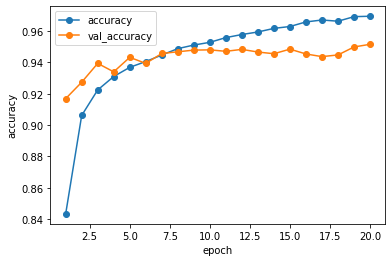

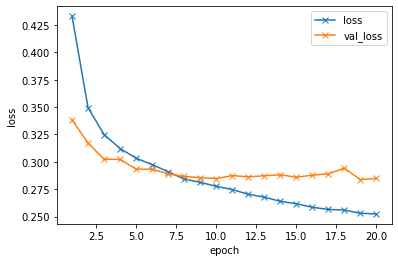

In [ ]:
# 学習経過の保存

dir_results = drive_path + '/results'
os.makedirs(os.path.join(dir_results, model_base), exist_ok=True)

#acc, val_accのプロット
epoch = range(1, len(hist["loss"]) + 1)
fig1 = plt.figure()
plt.plot(epoch, hist["accuracy"], label="accuracy", ls="-", marker="o")
plt.plot(epoch, hist["val_accuracy"], label="val_accuracy", ls="-", marker="o")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
figname = os.path.join(dir_results, model_base, "accuracy.png")
plt.savefig(figname)
plt.show()

fig2 = plt.figure()
plt.plot(epoch, hist["loss"], label="loss", ls="-", marker="x")
plt.plot(epoch, hist["val_loss"], label="val_loss", ls="-", marker="x")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(loc="best")
figname = os.path.join(dir_results, model_base, "loss.png")
plt.savefig(figname)
plt.show()

# ヒストリーの保存
df_training_log = pd.DataFrame(hist)
df_training_log['epoch'] = [i+1 for i in range(len(df_training_log))]
df_training_log = df_training_log.reindex(columns = ['epoch'] + list(hist.keys()))
save_log_excel_path = os.path.join(dir_results, model_base, "training_log.xlsx")
df_training_log.to_excel(save_log_excel_path)

histname = os.path.join(dir_results, model_base, "history.json")
with open(histname, 'w') as f:
    json.dump(hist, f, cls = MyEncoder)

In [ ]:
# model_base = model_base
best_epoch =  19# @param {type:"integer"}

get_custom_objects().update({'swish_act': SwishActivation(swish_act), 
                             'KerasLayer': KerasLayer})
model_final = load_model(os.path.join(model_dir, model_base, f'effcientnet_model_{best_epoch:02d}.h5'), 
                         custom_objects={'KerasLayer': KerasLayer})

# best_epoch の保存
best_epoch_path = os.path.join(model_dir, model_base, 'best_epoch.txt')
with open(best_epoch_path, 'w') as f:
    f.write(str(best_epoch))

U1366C_02_03_125_003_10693_21167.jpg
[[0.0676764  0.93232363]]
noise


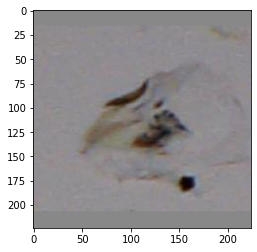

U1370D_07_02_148_001_17956_8292.jpg
[[0.08399007 0.9160099 ]]
noise


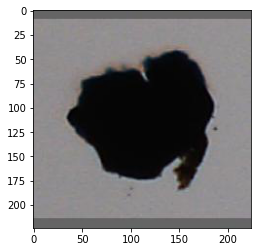

U1366C_02_05_100_019_10839_29494.jpg
[[0.1004888 0.8995112]]
noise


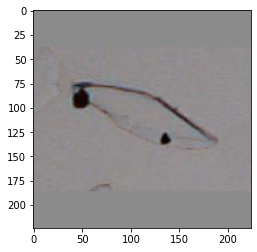

U1370D_07_02_148_004_7555_28757.jpg
[[0.91927916 0.08072083]]
tooth


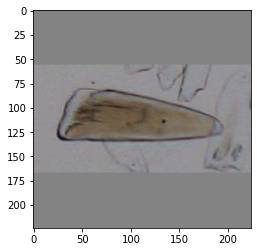

U1370D_07_02_148_006_7627_25049.jpg
[[0.9180196  0.08198044]]
tooth


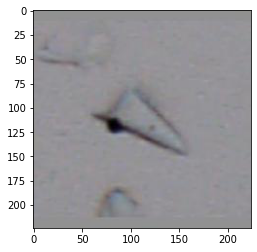

U1366C_02_05_100_008_10631_272.jpg
[[0.31460398 0.68539596]]
noise


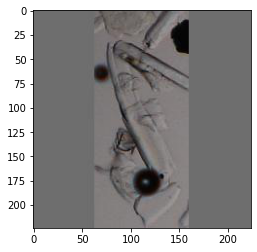

1179C_23_05_100_006_16188_20011.jpg
[[0.05720652 0.9427935 ]]
noise


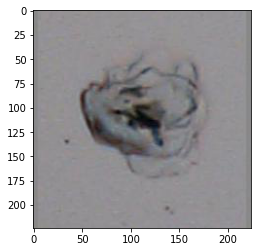

U1370D_07_02_148_006_3180_13486.jpg
[[0.9458137  0.05418627]]
tooth


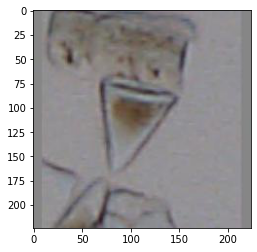

U1370D_07_04_148_007_16943_34893.jpg
[[0.821939   0.17806107]]
tooth


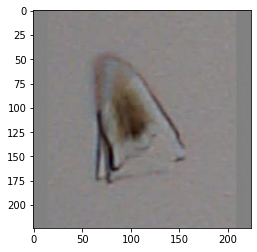

U1366C_02_01_125_009_6599_14133.jpg
[[0.05199856 0.94800144]]
noise


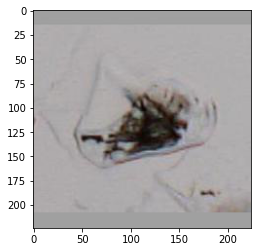

In [ ]:
# validation data の予測
num_validation_check = 10 # @param {type:"integer"}
for _ in range(num_validation_check):
    k = np.random.choice(validation_generator.n)
    path = validation_generator.filepaths[k]
    img = imread(path)
    PRED = model_final.predict(np.array([img/255]))
    pred = np.argmax(PRED, axis=1)
    print(os.path.basename(path))
    print(PRED)
    print(class_names[pred[0]])
    plt.imshow(img)
    plt.show()

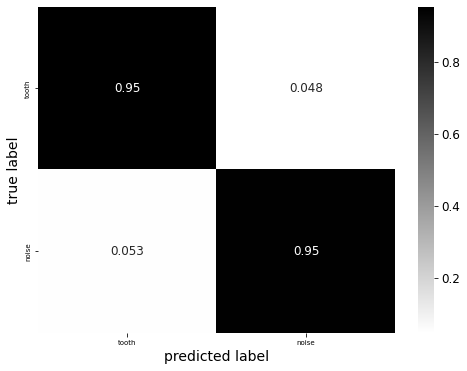

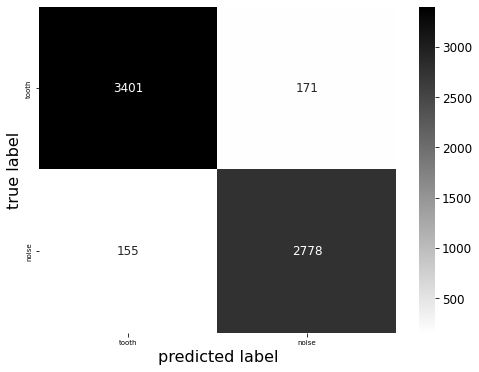

['tooth', 'noise']

In [ ]:
# validation data に対する分類精度
figsize = (int(len(validation_generator.class_indices) * 4), int(len(validation_generator.class_indices) * 3.2))
plt.figure(figsize=figsize)
plt.rcParams["font.size"] = 12

PRED = model_final.predict(validation_generator)
pred = np.argmax(PRED, axis=1)
ax = sns.heatmap(confusion_matrix(validation_generator.classes,
                                  pred, normalize='true'), 
                 cmap="binary",annot=True)
ax.set_xlabel('predicted label', fontsize = 14)
ax.set_ylabel('true label', fontsize = 14)
ax.set_xticklabels(list(validation_generator.class_indices.keys()), fontsize = 7)
ax.set_yticklabels(list(validation_generator.class_indices.keys()), fontsize = 7)
plt.show()


plt.figure(figsize=figsize)
plt.rcParams["font.size"] = 12

ax = sns.heatmap(confusion_matrix(validation_generator.classes,
                                  pred, normalize=None), 
                 cmap="binary",annot=True, fmt='d')
ax.set_xlabel('predicted label', fontsize = 16)
ax.set_ylabel('true label', fontsize = 16)
ax.set_xticklabels(list(validation_generator.class_indices.keys()), fontsize = 7)
ax.set_yticklabels(list(validation_generator.class_indices.keys()), fontsize = 7)
plt.show()
display(class_names)

In [ ]:
# # test data に対する分類精度
# PRED = model_final.predict(test_generator)
# pred = np.argmax(PRED, axis=1)

In [ ]:
# figsize = (int(len(test_generator.class_indices) * 4), int(len(test_generator.class_indices) * 3.2))
# plt.figure(figsize=figsize)
# plt.rcParams["font.size"] = 9
# ax = sns.heatmap(confusion_matrix(test_generator.classes,
#                                   pred, normalize='true'), 
#                  cmap="binary",annot=True)
# ax.set_xlabel('predicted label', fontsize = 14)
# ax.set_ylabel('true label', fontsize = 14)
# ax.set_xticklabels(class_names, fontsize = 7)
# ax.set_yticks([i + 0.5 for i in list(range(len(test_generator.class_indices)))])
# ax.set_yticklabels(list(test_generator.class_indices.keys()), fontsize = 12)
# plt.show()

# plt.figure(figsize=figsize)
# plt.rcParams["font.size"] = 9

# ax = sns.heatmap(confusion_matrix(test_generator.classes,
#                                   pred, normalize=None), 
#                  cmap="binary",annot=True, fmt='d')
# ax.set_xlabel('predicted label', fontsize = 16)
# ax.set_ylabel('true label', fontsize = 16)
# ax.set_xticklabels(class_names, fontsize = 7)
# ax.set_yticks([i + 0.5 for i in list(range(len(test_generator.class_indices)))])
# ax.set_yticklabels(list(test_generator.class_indices.keys()))
# plt.show()
# display(class_names)

In [ ]:
# # FN の表示

# num_fn_check =  20# @param {type:"integer"}

# fn_index = list(np.where((pred == 0) * (test_generator.classes == 1))[0])
# num_fn_check = min(num_fn_check, len(fn_index))
# for k in random.sample(fn_index, num_fn_check):
#     path = test_generator.filepaths[k]
#     img = imread(path)
#     PRED = model_final.predict(np.array([img/255]))
#     pred = np.argmax(PRED, axis=1)
#     print(os.path.basename(path))
#     print(PRED)
#     print(class_names[pred[0]])
#     plt.imshow(img)
#     plt.show()

In [ ]:
# 使用したライブラリのバージョンを表示
!pip install watermark
%load_ext watermark
%watermark -n -u -v -iv -w

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.8.2
    Uninstalling importlib-metadata-4.8.2:
      Successfully uninstalled importlib-metadata-4.8.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.2 which is incompatible.
Last updated: Fri Dec 24 2021

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

pandas        : 1.1.5
cv2           : 4.1.2
json          : 2.0.9
numpy         : 1.19.5
matplotlib    : 3.2.2
google        : 2.0.3
tensorflow_hub: 0.12.0
tensorflow    : 2.7.0
seaborn       : 0.11.2
IPython       : 5.5.0

Watermark: 2.2.0

